In [1]:
# import modules
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from modules.gan import ConditionalGenerator, ConditionalDiscriminator
from modules.losses import hinge_loss_discriminator, hinge_loss_generator, compute_gradient_penalty
from modules.set_seed import set_seed


In [ ]:
set_seed(42) # ensures reproducibility, comment before if you want to generate a new synthetic dataset each time you run the code


In [7]:
# dataset
DATASET = 'WEB_TARGET.csv' # change the dataset for GAN re-training
df = pd.read_csv(DATASET)
df.columns

Index(['Age', 'Sex', 'Ruptured', 'Circulation', 'Location', 'Ignore',
       'Max diameter in any dimension (mm)', 'Height (mm)', 'Width (mm)',
       'Other diameter', 'Neck (mm) orthogonal view 1',
       'Neck (mm) orthogonal view 2', 'Avg neck vol', 'Aneurysm 3D Volume',
       'WEB_1_Name', 'SL/Elongated', 'WEB_1_width', 'WEB_1_Height',
       'WEB Volume', 'WEB Device #2 name', 'WEB 2 Volume', 'Final WEB Volume',
       'Comments on why a second device needed',
       'Complete WEB failure/abandonment', 'Re-sizing required',
       'Stenting used to support WEB?', 'Composite outcome',
       'Procedure related ischemic stroke?', 'Intraop rupture', '3_mo_occ',
       '6_mo_occ', '1_year_occ', 'Dual_length'],
      dtype='object')

In [8]:
df.isnull().sum()

Age                                        0
Sex                                        0
Ruptured                                   0
Circulation                                0
Location                                   0
Ignore                                    55
Max diameter in any dimension (mm)         0
Height (mm)                                0
Width (mm)                                 0
Other diameter                            43
Neck (mm) orthogonal view 1                0
Neck (mm) orthogonal view 2                0
Avg neck vol                               0
Aneurysm 3D Volume                         0
WEB_1_Name                                 0
SL/Elongated                               0
WEB_1_width                                0
WEB_1_Height                               0
WEB Volume                                 0
WEB Device #2 name                        69
WEB 2 Volume                              69
Final WEB Volume                           0
Comments o

## GAN Training

In [9]:
# Features and data preparation
features = ['Age', 'Sex', 'Ruptured', 'Circulation',
            'Max diameter in any dimension (mm)', 'Height (mm)',
            'Width (mm)', 'Neck (mm) orthogonal view 1',
            'Neck (mm) orthogonal view 2', 'Avg neck vol', 'Aneurysm 3D Volume',
            'SL/Elongated', 'Final WEB Volume',
            'Complete WEB failure/abandonment', 'Re-sizing required',
            'Stenting used to support WEB?', 'Composite outcome',
            'Procedure related ischemic stroke?', 'Intraop rupture',
            '6_mo_occ']

data = df[features].copy()

ordinal_features = ['6_mo_occ']
binary_features = ['Sex', 'Ruptured', 'Circulation', 'SL/Elongated','Composite outcome',
                   'Complete WEB failure/abandonment', 'Re-sizing required',
                   'Stenting used to support WEB?', 'Intraop rupture',
                   'Procedure related ischemic stroke?']
continuous_features = [col for col in features if col not in binary_features + ordinal_features]

'''for col in ordinal_features:
    data[col].fillna(data[col].mode()[0], inplace=True)'''
data.fillna(data.mean(numeric_only=True), inplace=True)

scaler_continuous = MinMaxScaler()
scaler_ordinal = MinMaxScaler()
data[continuous_features] = scaler_continuous.fit_transform(data[continuous_features])
data[ordinal_features] = scaler_ordinal.fit_transform(data[ordinal_features])

X = data.values

# GAN parameters
latent_dim = 16
input_dim = X.shape[1]
binary_dim = len(binary_features)
continuous_dim = len(continuous_features)
ordinal_dim = len(ordinal_features)
epochs = 5000
batch_size = 16
learning_rate = 0.0002

# Initialize generator and discriminator
generator = ConditionalGenerator(latent_dim, binary_dim, continuous_dim, ordinal_dim)
discriminator = ConditionalDiscriminator(input_dim, binary_dim)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Binary conditions
binary_conditions = torch.tensor(X[:, :binary_dim], dtype=torch.float32)

# Training
initial_temperature = 0.2
final_temperature = 0.05
temperature_decay = (initial_temperature - final_temperature) / epochs

for epoch in range(epochs):
    current_temperature = max(final_temperature, initial_temperature - epoch * temperature_decay)
    generator.update_temperature(current_temperature)

    for _ in range(X.shape[0] // batch_size):
        real_idx = np.random.choice(X.shape[0], batch_size)
        real_data = torch.tensor(X[real_idx], dtype=torch.float32)
        real_conditions = binary_conditions[real_idx]

        noise = torch.randn(batch_size, latent_dim)
        fake_data = generator(noise, real_conditions)
        real_scores = discriminator(real_data, real_conditions)
        fake_scores = discriminator(fake_data.detach(), real_conditions)

        gp = compute_gradient_penalty(discriminator, real_data, fake_data, real_conditions)

        optimizer_d.zero_grad()
        loss_d = hinge_loss_discriminator(real_scores, fake_scores) + 10 * gp
        loss_d.backward()
        optimizer_d.step()

        noise = torch.randn(batch_size, latent_dim)
        fake_data = generator(noise, real_conditions)
        fake_scores = discriminator(fake_data, real_conditions)

        optimizer_g.zero_grad()
        loss_g = hinge_loss_generator(fake_scores)
        loss_g.backward()
        optimizer_g.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}/{epochs} | Loss D: {loss_d.item():.4f} | Loss G: {loss_g.item():.4f} | Temp: {current_temperature:.4f}")


Epoch 0/5000 | Loss D: 10.5551 | Loss G: -0.0955 | Temp: 0.2000
Epoch 500/5000 | Loss D: 0.8131 | Loss G: 0.6156 | Temp: 0.1850
Epoch 1000/5000 | Loss D: 2.1465 | Loss G: -0.2625 | Temp: 0.1700
Epoch 1500/5000 | Loss D: 1.9562 | Loss G: -0.2555 | Temp: 0.1550
Epoch 2000/5000 | Loss D: 1.9158 | Loss G: 0.1800 | Temp: 0.1400
Epoch 2500/5000 | Loss D: 1.6906 | Loss G: 0.0303 | Temp: 0.1250
Epoch 3000/5000 | Loss D: 1.7757 | Loss G: 0.1259 | Temp: 0.1100
Epoch 3500/5000 | Loss D: 1.7502 | Loss G: 0.1722 | Temp: 0.0950
Epoch 4000/5000 | Loss D: 1.7309 | Loss G: 0.0537 | Temp: 0.0800
Epoch 4500/5000 | Loss D: 1.6176 | Loss G: 0.1889 | Temp: 0.0650


### Once GAN is trained, generate augmented data

In [ ]:
# Generate data
set_seed(42)  # ensures reproducibility, comment before if you want to generate a new synthetic dataset each time you run the code
num_samples = 1000 # change the number of samples to generate
noise = torch.randn(num_samples, latent_dim)

if num_samples > len(binary_conditions):
    conditions = binary_conditions.repeat((num_samples // len(binary_conditions)) + 1, 1)[:num_samples]
else:
    conditions = binary_conditions[:num_samples]

synthetic_data = generator(noise, conditions).detach().numpy()

# Post-processing
synthetic_df = pd.DataFrame(synthetic_data, columns=features)
synthetic_df[continuous_features] = scaler_continuous.inverse_transform(synthetic_df[continuous_features])
synthetic_df[ordinal_features] = scaler_ordinal.inverse_transform(synthetic_df[ordinal_features])

for col in ordinal_features:
    synthetic_df[col] = synthetic_df[col].round().astype(int)

synthetic_df[binary_features] = synthetic_df[binary_features].round().astype(int)

print(synthetic_df.head())  

         Age  Sex  Ruptured  Circulation  Max diameter in any dimension (mm)  \
0  47.867943    1         1            1                            6.002412   
1  34.138096    1         1            1                            7.789716   
2  63.140549    0         0            1                            9.941943   
3  41.078133    0         1            1                            4.849174   
4  42.025032    0         0            1                            4.490042   

   Height (mm)  Width (mm)  Neck (mm) orthogonal view 1  \
0     6.049528    6.394805                     3.338446   
1     7.978728    7.625263                     6.903481   
2    11.252902    7.171926                     3.435490   
3     4.888848    4.683253                     2.523213   
4     4.320090    3.765110                     3.185787   

   Neck (mm) orthogonal view 2  Avg neck vol  Aneurysm 3D Volume  \
0                     2.598765      2.962570          114.067146   
1                     4.1423

## Evaluate Quality of Generated Data

In [26]:
import pandas as pd
from scipy.stats import ks_2samp, wasserstein_distance
from scipy.spatial.distance import jensenshannon
import numpy as np
from modules.gan_evaluation import ks_test, js_divergence, emd

# Kolmogorov-Smirnov Test
ks_results = {feature: ks_test(df[feature].dropna(), synthetic_df[feature].dropna()) for feature in continuous_features}

# Jensen-Shannon Divergence
jsd_results = {feature: js_divergence(df[feature].dropna(), synthetic_df[feature].dropna()) for feature in continuous_features}

# Earth Mover's Distance (Wasserstein Distance)
emd_results = {feature: emd(df[feature].dropna(), synthetic_df[feature].dropna()) for feature in continuous_features}

# Binary features comparison
binary_comparison = {feature: {"Original Proportion": df[feature].mean(skipna=True), "Synthetic Proportion": synthetic_df[feature].mean(skipna=True)} for feature in binary_features}

ks_results_df = pd.DataFrame(ks_results).T
jsd_results_df = pd.DataFrame(jsd_results, index=["Jensen-Shannon Divergence"]).T
emd_results_df = pd.DataFrame(emd_results, index=["Earth Mover's Distance"]).T
binary_comparison_df = pd.DataFrame(binary_comparison).T

print("Kolmogorov-Smirnov Test Results for Continuous Features:")
print(ks_results_df)

print("\nJensen-Shannon Divergence for Continuous Features:")
print(jsd_results_df)

print("\nEarth Mover's Distance for Continuous Features:")
print(emd_results_df)

print("\nComparison of Proportions for Binary Features:")
print(binary_comparison_df)


Kolmogorov-Smirnov Test Results for Continuous Features:
                                    KS Statistic   p-value
Age                                     0.087795  0.599161
Max diameter in any dimension (mm)      0.061308  0.931821
Height (mm)                             0.071231  0.828967
Width (mm)                              0.048410  0.992477
Neck (mm) orthogonal view 1             0.071436  0.826348
Neck (mm) orthogonal view 2             0.123564  0.200795
Avg neck vol                            0.057744  0.956901
Aneurysm 3D Volume                      0.095769  0.488931
Final WEB Volume                        0.116385  0.258872

Jensen-Shannon Divergence for Continuous Features:
                                    Jensen-Shannon Divergence
Age                                                  0.266575
Max diameter in any dimension (mm)                   0.220024
Height (mm)                                          0.215628
Width (mm)                                           

In [29]:
# Ordinal features (Target variable)
ks_results_ordinal = {}
jsd_results_ordinal = {}
freq_comparison_ordinal = {}

for feature in ordinal_features:
    try:
        original = df[feature].dropna()
        synthetic = synthetic_df[feature].dropna()

        # KS Test
        ks_stat, p_value = ks_2samp(original, synthetic)
        ks_results_ordinal[feature] = {"KS Statistic": ks_stat, "p-value": p_value}

        # Jensen-Shannon Divergence
        num_bins = max(len(original.unique()), len(synthetic.unique()))
        original_hist, _ = np.histogram(original, bins=num_bins, range=(original.min(), original.max()), density=True)
        synthetic_hist, _ = np.histogram(synthetic, bins=num_bins, range=(original.min(), original.max()), density=True)
        jsd = jensenshannon(original_hist, synthetic_hist)
        jsd_results_ordinal[feature] = jsd

        # Frequency Comparison
        original_freq = original.value_counts(normalize=True).sort_index()
        synthetic_freq = synthetic.value_counts(normalize=True).sort_index()
        freq_comparison = pd.DataFrame({'Original': original_freq, 'Synthetic': synthetic_freq}).fillna(0)
        freq_comparison_ordinal[feature] = freq_comparison

    except Exception as e:
        ks_results_ordinal[feature] = {"KS Statistic": None, "p-value": None, "Error": str(e)}
        jsd_results_ordinal[feature] = None
        freq_comparison_ordinal[feature] = None

ks_results_ordinal_df = pd.DataFrame(ks_results_ordinal).T
jsd_results_ordinal_df = pd.DataFrame(jsd_results_ordinal, index=["Jensen-Shannon Divergence"]).T

print("Kolmogorov-Smirnov Test Results for Ordinal Features:")
print(ks_results_ordinal_df)

print("\nJensen-Shannon Divergence for Ordinal Features:")
print(jsd_results_ordinal_df)

print("\nFrequency Comparison for Ordinal Features:")
for feature, comparison in freq_comparison_ordinal.items():
    if comparison is not None:
        print(f"\n{feature} Frequency Comparison:")
        print(comparison)
    else:
        print(f"\n{feature} Frequency Comparison: None")


Kolmogorov-Smirnov Test Results for Ordinal Features:
          KS Statistic   p-value
6_mo_occ      0.072051  0.818711

Jensen-Shannon Divergence for Ordinal Features:
          Jensen-Shannon Divergence
6_mo_occ                    0.13049

Frequency Comparison for Ordinal Features:

6_mo_occ Frequency Comparison:
          Original  Synthetic
6_mo_occ                     
0         0.538462      0.525
1         0.102564      0.164
2         0.076923      0.101
3         0.256410      0.144
4         0.025641      0.066


# Visualize

c:\Users\shrin\anaconda3\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = contour_func(


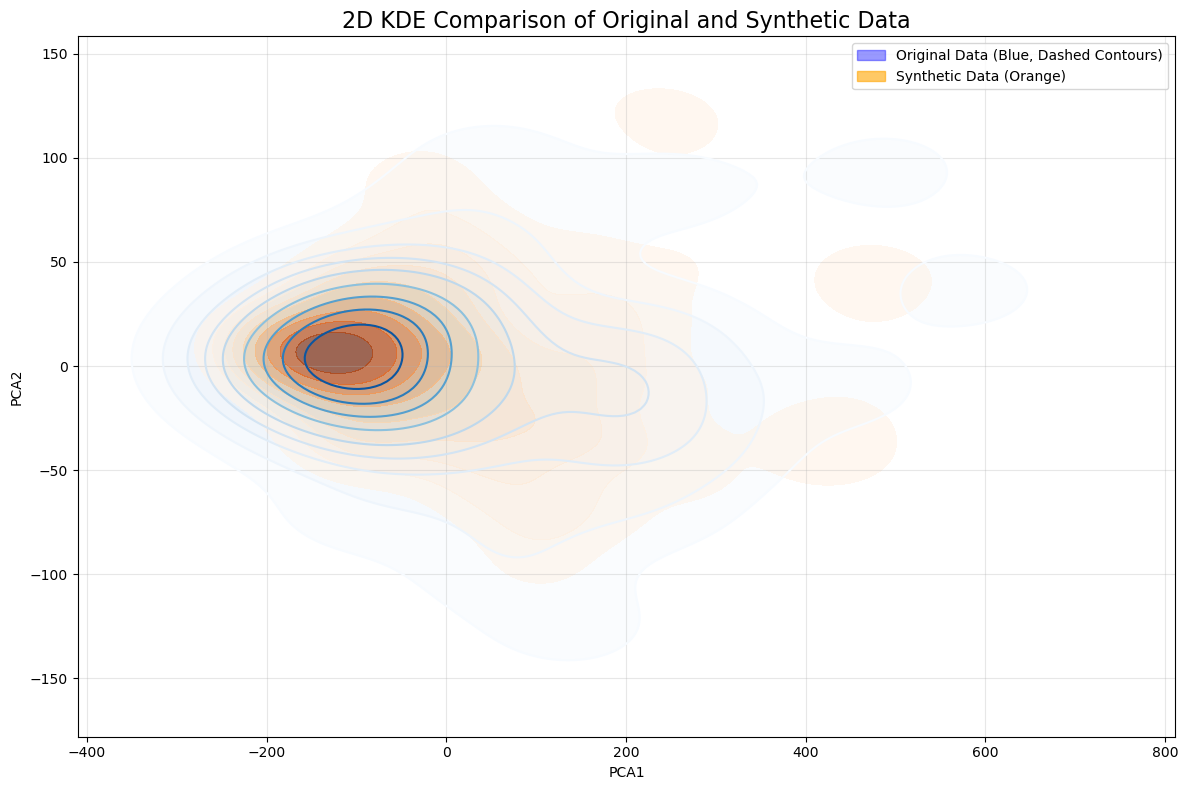

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.patches import Patch

features_to_compare = features
original_df = df 

# PCA for dimensionality reduction 
if len(features_to_compare) > 2:
    pca = PCA(n_components=2)
    original_pca = pca.fit_transform(original_df[features_to_compare].fillna(0))
    synthetic_pca = pca.transform(synthetic_df[features_to_compare].fillna(0))
    features_for_plot = ['PCA1', 'PCA2']
    original_plot = pd.DataFrame(original_pca, columns=features_for_plot)
    synthetic_plot = pd.DataFrame(synthetic_pca, columns=features_for_plot)
else:
    original_plot = original_df[features_to_compare].dropna()
    synthetic_plot = synthetic_df[features_to_compare].dropna()

# KDE plots for original and synthetic data
plt.figure(figsize=(12, 8))

# KDE: Original Data 
sns.kdeplot(
    x=original_plot.iloc[:, 0], 
    y=original_plot.iloc[:, 1],
    cmap="Blues", 
    fill=True, 
    alpha=0.4,  
    label='Original Data (Blue)'
)

sns.kdeplot(
    x=original_plot.iloc[:, 0], 
    y=original_plot.iloc[:, 1],
    cmap="Blues",
    fill=False, 
    alpha=1,  
    linestyle='--',  
    linewidths=1.5
)

# KDE: Synthetic Data
sns.kdeplot(
    x=synthetic_plot.iloc[:, 0], 
    y=synthetic_plot.iloc[:, 1],
    cmap="Oranges", 
    fill=True, 
    alpha=0.6,
    label='Synthetic Data (Orange)'
)

# legend
legend_elements = [
    Patch(facecolor='blue', edgecolor='blue', alpha=0.4, label='Original Data (Blue, Dashed Contours)'),
    Patch(facecolor='orange', edgecolor='orange', alpha=0.6, label='Synthetic Data (Orange)')
]
plt.legend(handles=legend_elements, loc='upper right')

# plot
plt.title("2D KDE Comparison of Original and Synthetic Data", fontsize=16)
plt.xlabel(features_to_compare[0] if len(features_to_compare) == 2 else "PCA1")
plt.ylabel(features_to_compare[1] if len(features_to_compare) == 2 else "PCA2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Save new data to CSV

In [ ]:
synthetic_df.to_csv('synthetic_data.csv', index=False) # save to CSV file